In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import logging 
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from collections import defaultdict
from math import sqrt
from multiprocessing.dummy import Pool as ThreadPool 

In [4]:
df = pd.read_csv("sumo_out.csv",delimiter=";").dropna()
df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
1,1.0,0.0,from0.0,0_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,1.65,8.35
2,2.0,0.0,from0.0,0_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,1.65,9.15
3,2.0,90.0,from1.0,1_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,8.35,498.35
4,3.0,0.0,from0.0,0_0,7.5,0.0,1.6,SUMO_DEFAULT_TYPE,1.65,10.75
5,3.0,90.0,from1.0,1_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,9.15,498.35


In [5]:
car_groups = df.sort_values(by='timestep_time').groupby('vehicle_id')

In [6]:
cars = df['vehicle_id'].unique()

In [7]:
car0_df = car_groups.get_group(cars[0])
car0_df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
1,1.0,0.0,from0.0,0_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,1.65,8.35
2,2.0,0.0,from0.0,0_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,1.65,9.15
4,3.0,0.0,from0.0,0_0,7.5,0.0,1.6,SUMO_DEFAULT_TYPE,1.65,10.75
7,4.0,0.0,from0.0,0_0,9.9,0.0,2.4,SUMO_DEFAULT_TYPE,1.65,13.15
11,5.0,0.0,from0.0,0_0,13.1,0.0,3.2,SUMO_DEFAULT_TYPE,1.65,16.35


Below is a figure of how a sample car moves in the x and y coordinates

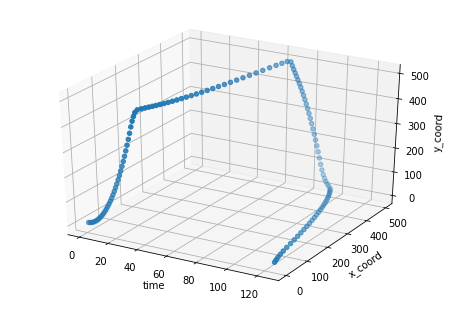

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(car0_df['timestep_time'],car0_df['vehicle_x'] , car0_df['vehicle_y'])
ax.set_xlabel("time")
ax.set_ylabel("x_coord")
ax.set_zlabel("y_coord")
plt.show()

The manual and hardest part of the simulation is positioning the antennas. Note that below, we will position the antennas in an algorithmic fashion; however, this algorithm may not be in fact the most optimal positioning as it does not take into account real life variables such as signal strength and packet loss

All cars travel the same box shaped route, so we will determine the position of the antenas from the routes of the cars

In [9]:
coords_x,coords_y = df['vehicle_x'],df['vehicle_y']

Given the minimum and maximum x and y coordinates along the range of the antennas we will place the antennas s.t they cover each of these coordinates and maximize the coverage with other coordinates. 
Note that when stating cover we refer that the eucledian distance between an antenna and a point is less than or equal to the range of the antenna

In [10]:
ANTENNA_RANGE=100

In [11]:
#Returns a list of 4 tuples for the x and y coordinates of the antennas in the box shaped simulation
def get_antena_coords(coords_x,coords_y,antenna_range=200):
    min_x,max_x = min(coords_x),max(coords_x)
    min_y,max_y = min(coords_y),max(coords_y)
    d = sqrt(antenna_range**2/2)
    return [(min_x+d,min_y+d),(min_x+d,max_y-d),(max_x-d,max_y-d),(max_x-d,min_y+d)]

In [12]:
def plot_antennas(antenna_coords,antenna_range,coords_x,coords_y):
    fig, ax = plt.subplots()
    plt.scatter(coords_x,coords_y)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.title("Antennas")
    for antenna_coord in antenna_coords:
        antenna = plt.Circle(antenna_coord,antenna_range)
        ax.add_artist(antenna)
    plt.show()

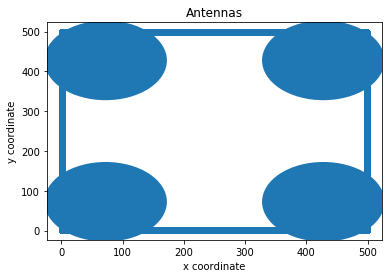

In [13]:
antenna_coords = get_antena_coords(coords_x,coords_y,antenna_range=ANTENNA_RANGE)
plot_antennas(antenna_coords,ANTENNA_RANGE,coords_x,coords_y)


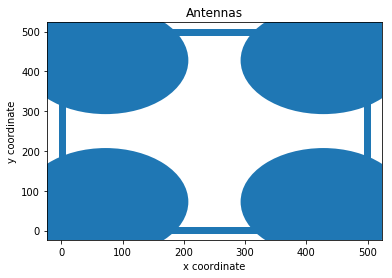

In [33]:
plot_antennas(antenna_coords,135,coords_x,coords_y)

Now that we have established how we will place the antennas and we have plotted the range of the antennas on the grid, we will establish the data structures used for the simulation

In [15]:
class Packet:
    def __init__(self,identifier,size):
        self.identifier = identifier
        self.size = size
    def __eq__(self, other):
        return other and self.identifier == other.identifier

In [16]:
class Antenna:
    def __init__(self,antenna_id,x,y,ant_range,packets,bandwith):
        self.id = antenna_id
        self.x = x
        self.y = y
        self.ant_range = ant_range
        self.packets = packets
        self.bandwith = bandwith
        
    def in_range(self,other_x,other_y):
        return distance.euclidean((self.x,self.y), (other_x,other_y))<=self.ant_range
    
    def has_packet(self, packet):
        return packet in self.packets
    
    def get_data(self):
        return self.bandwith

In [154]:
class Node:
    def __init__(self,df,packets):
        self.id = df.iloc[0]['vehicle_id']
        self.df = df
        self.packets = packets[:]
        #Note the one to one relationship between packet and antenna
        self.antenna_to_packet = defaultdict(lambda: (None,0))
    
    def find_packet(self,antenna):
        for index,packet in enumerate(self.packets):
            if antenna.has_packet(packet):
                self.packets.pop(index)
                return packet
        return None
    
    def download_packet(self,x,y,antenna):
        if not antenna.in_range(x,y):
            packet,progress = self.antenna_to_packet[antenna]
            if packet!=None:
                info = "Stopping download for packet {} on car {} with antenna {}, last progress : {}".format(packet.identifier,self.id,antenna.id,progress)
                logging.info(info)
                self.packets.append(packet)
            self.antenna_to_packet[antenna] = (None,0)
        elif self.antenna_to_packet[antenna][0]==None:
            packet = self.find_packet(antenna)
            if packet!=None:
                info = "Initiated download for packet {} on car {} with antenna {}".format(packet.identifier,self.id,antenna.id)
                logging.info(info)
            self.antenna_to_packet[antenna]=(packet,0)
        else:
            packet,progress = self.antenna_to_packet[antenna]
            progress +=antenna.get_data()
            info = "Continuing download for packet {} on car {} with antenna {} latest progress: {}".format(packet.identifier,self.id,antenna.id,progress)
            logging.info(info)
            if progress>=packet.size:
                info = "Download finished for packet {} on car {} with antenna {}".format(packet.identifier,self.id,antenna.id)
                logging.info(info)
                self.antenna_to_packet[antenna]=(None,0)
            else:
                self.antenna_to_packet[antenna]=(packet,progress)                    
   
    def get_packets_dowmloading(self):
        packets_downloading = 0
        for antenna in self.antenna_to_packet:
            packet,progress = self.antenna_to_packet[antenna]
            if packet!=None:
                packets_downloading+=1
        return packets_downloading
    
    def simulate(self,antennas):
        logging.info("Id {}".format(self.id))
        total_packets = len(self.packets)
        for index, row in self.df.iterrows():
            x,y,time = row['vehicle_x'],row['vehicle_y'],row['timestep_time']
            logging.info("Time {}".format(time))
            for antenna in antennas:
                self.download_packet(x,y,antenna)
        self.packets_downloaded = total_packets-self.get_packets_dowmloading()- len(self.packets)
        return self.id, self.packets_downloaded
                
                
                
                
                
                

Below we will test out data structures with a sample simulation with one car, one antenna and one packet for that car


In [168]:
def test():
    logging.getLogger().setLevel(logging.INFO)
    packets = [Packet(0,10)]
    x,y = antenna_coords[0]
    bandwith = .01
    antenna = Antenna(0,x,y, ANTENNA_RANGE,packets,.01)
    node  = Node(0,car0_df[0:10],packets) #Note that we sliced the rows of the df to minimize output 
    stats = node.simulate([antenna])
    logging.info("Stats : {}".format(stats))

In [35]:
test()

INFO:root:Time 1.0
INFO:root:Initiated download for packet 0 on car from0.0 with antenna 0
INFO:root:Time 2.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.01
INFO:root:Time 3.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.02
INFO:root:Time 4.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.03
INFO:root:Time 5.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.04
INFO:root:Time 6.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.05
INFO:root:Time 7.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.060000000000000005
INFO:root:Time 8.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 latest progress: 0.07
INFO:root:Time 9.0
INFO:root:Continuing download for packet 0 on car from0.0 with antenna 0 lat

Now that we have created the simulation framework and tested it with one node, one packet and  one antenna. We will now test it with one node,4 packets and 4 antennas

In [36]:
def test2():
    logging.getLogger().setLevel(logging.INFO)
    n,bandwith = 4,0.01
    packets = [Packet(n,10) for i in range(n)]
    antennas = [Antenna(0,antenna_coords[i][0],antenna_coords[i][1], ANTENNA_RANGE,[packets[i]],bandwith) for i in range(n)] 
    node  = Node(0,car0_df[0:40],packets) #Note that we sliced the rows of the df to minimize output 
    stats= node.simulate(antennas)
    logging.info("Stats : {}".format(stats))

In [37]:
test2()

INFO:root:Time 1.0
INFO:root:Initiated download for packet 4 on car from0.0 with antenna 0
INFO:root:Time 2.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.01
INFO:root:Time 3.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.02
INFO:root:Time 4.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.03
INFO:root:Time 5.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.04
INFO:root:Time 6.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.05
INFO:root:Time 7.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.060000000000000005
INFO:root:Time 8.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 latest progress: 0.07
INFO:root:Time 9.0
INFO:root:Continuing download for packet 4 on car from0.0 with antenna 0 lat

Now that we have tested the simulator thoroughly we will simulate the scenario with all the cars and record the packets download for each car. Also we will copy the packets twice and distribute them evenly among the antennas

In [180]:
def simulation():
    logging.getLogger().setLevel(logging.WARN)
    n = 4 #Four packets and four antennas
    bandwith = .65
    packets = [Packet(n,10) for i in range(n)]
    antennas = []
    antennas = [Antenna(i,antenna_coords[i][0],antenna_coords[i][1], ANTENNA_RANGE,[packets[i],packets[len(packets)-1-i]],bandwith) for i in range(n)] 
    nodes = []
    for car in cars:
        car_df = car_groups.get_group(car)
        node = Node(car_df,packets)
        nodes.append(node)
    pool = ThreadPool(100) 
    results = pool.map(lambda node:node.simulate(antennas), nodes)
    return results

In [181]:
stats = simulation()

In [128]:
def make_data_frame(stats):
    id_,packets_received = [stats[i][0] for i in range(len(stats))],[stats[i][1] for i in range(len(stats))]
    d = {"id":id_,"packets_received":packets_received}
    df = pd.DataFrame(data=d)
    return df

In [182]:
stats_df = make_data_frame(stats)
stats_df.head()

,id,packets_received
0,from0.0,3
1,from1.0,3
2,from2.0,3
3,from3.0,3
4,from0.1,3


(array([ 79.,   0.,   0., 521.,   0.,   0., 929.,   0.,   0., 475.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

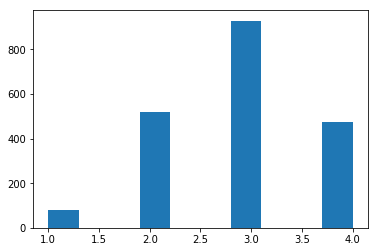

In [183]:
plt.hist(stats_df['packets_received'])